# A thalamo-cortical model of post-sleep memory improvement

*Bruna, Catalina and Flávio.*

LASCON 2024

In this Jupyter Notebook, we are going to model a thalamo-cortical model of post-sleep memory improvement. This project reproducts the paper ["Sleep-like slow oscillations improve visual classification through synaptic homeostasis and memory association in a thalamo-cortical model"](https://www.nature.com/articles/s41598-019-45525-0), whose code is not publicly available. The project is also part of the activities developed during LASCON 2024. 

In this notebook, we will go step by step in:

1. Model testing
2. Implementing MNSIT classification
3. Reproducting the paper's results

You can find model creatin details in network.py file.

Let's start. :)

-------------------------------

Importing libraries

In [1]:
import nest
import matplotlib.pyplot as plt
import seaborn as sns

from model.network import Network


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Jul 22 2023 00:00:00

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## 1. Model testing

In this section, I'm going to test the implementation of the class Network. This class creeates the thalamo-cortical network by declaring the cx population, which varies accodrdingly to the training phase.

In [2]:
# Reset Kernel
nest.ResetKernel()
nest.update_time_limit = 10.

In [3]:
# Instantiate the network with cx population of 180 neurons
net = Network(180)

In [4]:
# Print number of connections
print(nest.num_connections)

430640


In [5]:
# Get Default setting
nest.GetDefaults('aeif_cond_alpha')

{'a': 4.0,
 'archiver_length': 0,
 'available': (696,),
 'b': 80.5,
 'beta_Ca': 0.001,
 'C_m': 281.0,
 'Ca': 0.0,
 'capacity': (1600,),
 'Delta_T': 2.0,
 'dg_ex': 0.0,
 'dg_in': 0.0,
 'E_L': -70.6,
 'E_ex': 0.0,
 'E_in': -85.0,
 'element_type': 'neuron',
 'elementsize': 752,
 'frozen': False,
 'g_L': 30.0,
 'g_ex': 0.0,
 'g_in': 0.0,
 'global_id': 0,
 'gsl_error_tol': 1e-06,
 'I_e': 0.0,
 'instantiations': (904,),
 'local': True,
 'model': 'aeif_cond_alpha',
 'model_id': 80,
 'node_uses_wfr': False,
 'post_trace': 0.0,
 'recordables': ('g_ex', 'g_in', 'V_m', 'w'),
 'synaptic_elements': {},
 't_ref': 0.0,
 't_spike': -1.0,
 'tau_Ca': 10000.0,
 'tau_minus': 20.0,
 'tau_minus_triplet': 110.0,
 'tau_syn_ex': 0.2,
 'tau_syn_in': 2.0,
 'tau_w': 144.0,
 'thread': 0,
 'thread_local_id': -1,
 'type_id': 'aeif_cond_alpha',
 'V_m': -70.6,
 'V_peak': -40.4,
 'V_reset': -60.0,
 'V_th': -50.4,
 'vp': -1,
 'w': 0.0}

In order to measure the populations' properties, we call the multimeter and spike recorder devices.

In [6]:
# Multimeter and spike recorder for each population

# cx
multimeter_cx = nest.Create("multimeter")
multimeter_cx.set(record_from=["V_m"])

spikerecorder_cx = nest.Create("spike_recorder")

# in
multimeter_in = nest.Create("multimeter")
multimeter_in.set(record_from=["V_m"])

spikerecorder_in = nest.Create("spike_recorder")

# tc
multimeter_tc = nest.Create("multimeter")
multimeter_tc.set(record_from=["V_m"])

spikerecorder_tc = nest.Create("spike_recorder")

# re
multimeter_re = nest.Create("multimeter")
multimeter_re.set(record_from=["V_m"])

spikerecorder_re = nest.Create("spike_recorder")

Connect them to all populations.

In [7]:
# Connect the multimeter to all populations
nest.Connect(multimeter_cx, net.cx_pop)
nest.Connect(multimeter_in, net.in_pop)
nest.Connect(multimeter_tc, net.tc_pop)
nest.Connect(multimeter_re, net.re_pop)

# Connect the spike_recorder to all populations
nest.Connect(net.cx_pop, spikerecorder_cx)
nest.Connect(net.in_pop, spikerecorder_in)
nest.Connect(net.tc_pop, spikerecorder_tc)
nest.Connect(net.re_pop, spikerecorder_re)

Now we can run the simulation.

In [8]:
# Run simulation
nest.Simulate(500.0)


Jan 23 13:27:10 NodeManager::prepare_nodes [Info]: 
    Preparing 912 nodes for simulation.

Jan 23 13:27:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 912
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Jan 23 13:27:15 SimulationManager::run [Info]: 
    Simulation finished.


In [9]:
# Get events from multimeter
cx_vm = multimeter_cx.get()
vm_cx = cx_vm["events"]["V_m"]
ts_vm_cx = cx_vm["events"]["times"]

# Get events from spike recorder
cx_spike = spikerecorder_cx.get("events")
send_cx = cx_spike["senders"]
ts_spike_cx = cx_spike["times"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


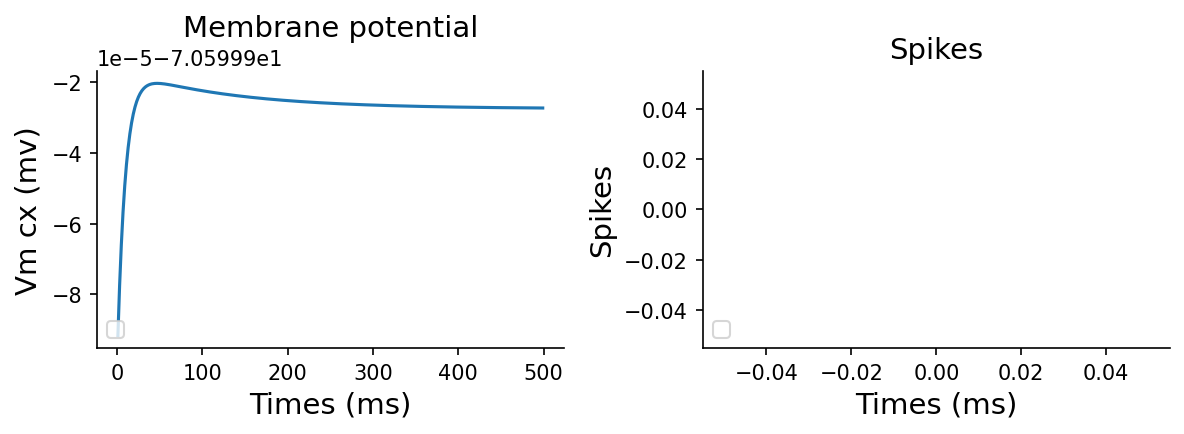

In [11]:
# Plot results

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(8, 3), sharey=False)

axs[0].plot(ts_vm_cx, vm_cx)
axs[0].set_title('Membrane potential', size=14)
axs[0].legend(loc=3)
axs[0].set_xlabel("Times (ms)", size=14)
axs[0].set_ylabel("Vm cx (mv)", size=14)

axs[1].plot(ts_spike_cx, send_cx)
axs[1].set_title('Spikes', size=14)
axs[1].legend(loc=3)
axs[1].set_xlabel("Times (ms)", size=14)
axs[1].set_ylabel("Spikes", size=14)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

Input a training signal do the tc population to test method implementation.

In [12]:
# Input training signal to the network
net.input_contextual_signal()

Contextual signal successfully connected to the cx population.


In [13]:
# Run simulation
nest.Simulate(500.0)


Jan 23 13:28:38 NodeManager::prepare_nodes [Info]: 
    Preparing 913 nodes for simulation.

Jan 23 13:28:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 913
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Jan 23 13:28:46 SimulationManager::run [Info]: 
    Simulation finished.


In [14]:
# Get events from multimeter
cx_vm = multimeter_cx.get()
vm_cx = cx_vm["events"]["V_m"]
ts_vm_cx = cx_vm["events"]["times"]

# Get events from spike recorder
cx_spike = spikerecorder_cx.get("events")
send_cx = cx_spike["senders"]
ts_spike_cx = cx_spike["times"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


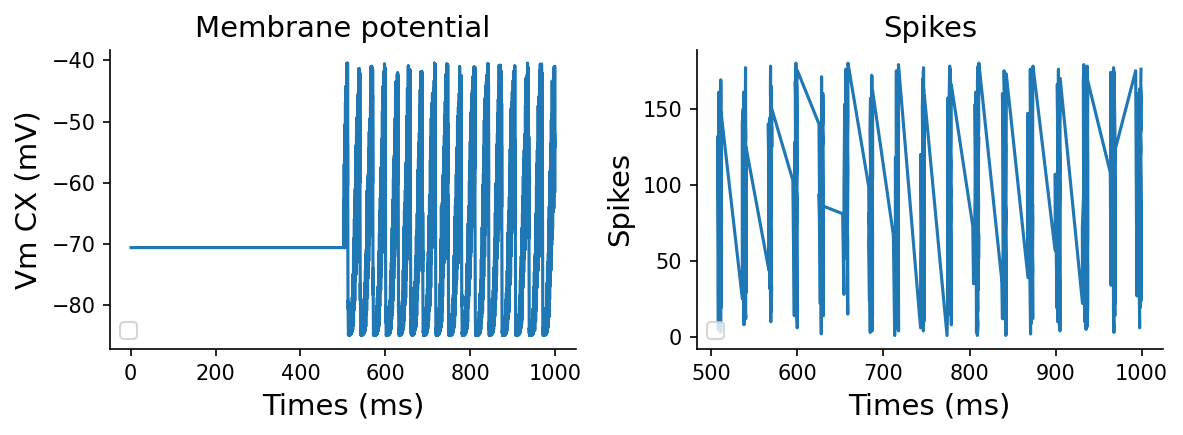

In [15]:
# Plot results

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(8, 3), sharey=False)

axs[0].plot(ts_vm_cx, vm_cx)
axs[0].set_title('Membrane potential', size=14)
axs[0].legend(loc=3)
axs[0].set_xlabel("Times (ms)", size=14)
axs[0].set_ylabel("Vm CX (mV)", size=14)  # Fixed the ylabel, and "mV" is commonly used for millivolts

axs[1].plot(ts_spike_cx, send_cx)
axs[1].set_title('Spikes', size=14)
axs[1].legend(loc=3)
axs[1].set_xlabel("Times (ms)", size=14)
axs[1].set_ylabel("Spikes", size=14)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
sns.despine()
plt.show()

Input inhibitory signal to the inhibitory interneurons (in) population.

In [16]:
net.input_inhib_signal()

Inhibitory signal successfully connected to the in population.


In [17]:
# Run simulation
nest.Simulate(500.0)


Jan 23 13:29:03 NodeManager::prepare_nodes [Info]: 
    Preparing 914 nodes for simulation.

Jan 23 13:29:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 914
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Jan 23 13:29:15 SimulationManager::run [Info]: 
    Simulation finished.


In [18]:
# Get events from multimeter
in_mult = multimeter_in.get()
vm_in = in_mult["events"]["V_m"]
ts_vm_in = in_mult["events"]["times"]

# Get events from spike recorder
in_spikerec = spikerecorder_in.get("events")
#sps = spikerecorder["events"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Vm cx (mv)')

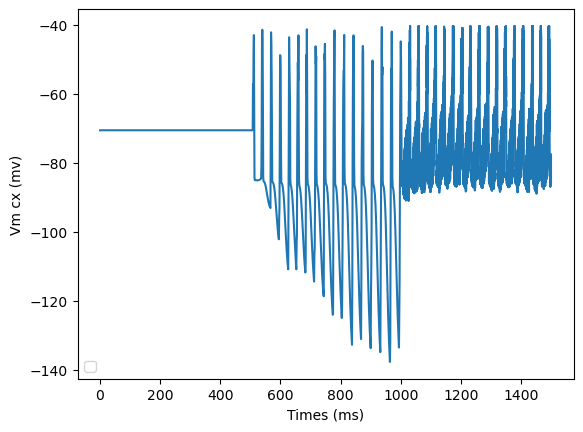

In [19]:
# Plot results
plt.plot(ts_vm_in, vm_in)
plt.legend(loc=3)
plt.xlabel("Times (ms)")
plt.ylabel("Vm cx (mv)")